<a href="https://colab.research.google.com/github/caesarcc/pucminas-tcc-fake-news-detection/blob/main/passo03_pre_processamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-Processamento e limpeza do dataset

### Iniciando pela configuração do Google Colab

In [2]:
# Instalação de libs que não estão presentes no Colab
!pip install emoji
!pip install -q transformers
!pip install -q sentencepiece
# Configuração da lib Spacy
!python -m spacy download pt_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 7.9 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=8037b649e7adb1ef03c2ad216d9bddf8b3be551b562b83aa29b44aa397ec970c
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
     |████████████████████████████████| 4.4 MB 9.7 MB/s 
     |████████████████████████████████| 6.6 MB 44.5 MB/s 
     |████████████████████████████████| 596 kB 59.1 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 8.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 9.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [3]:
# Configura acesso ao Google Driver onde serão salvos os arquivos grandes
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# Importação de bibliotecas utilizadas no pré-processamento
import os
import re
import emoji
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pt_core_news_sm
from transformers import T5TokenizerFast
from transformers import T5ForConditionalGeneration
from wordcloud import WordCloud
from IPython.display import display
%matplotlib inline
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 0)

### Carregar arquivo CSV das bases unificadas e validar

In [21]:
dados = pd.read_csv(r'/content/drive/MyDrive/PUC/TCC/dados/datasets_unificados.csv', sep = ',', names=['texto', 'classe'], header=1).reset_index(drop=True)
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   9537 non-null   object
 1   classe  9537 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.1+ KB


In [22]:
dados[dados['texto'].str.len()<400].sample(n=5)

,texto,classe
8623,"Barra da Tijuca, Rio, após entrevista do Bolsonaro no Jornal Nacional.",0
9471,O Bolsonaro vai ser bom? \nO futuro dirá! \n\nO PT vai ser bom?\nO passado já disse!,0
8680,O Vice-presidente da Guiné Equatorial foi preso ao tentar entrar no Brasil com alguns milhões de dólares em dinheiro. Por coincidência é o país que o Lula perdoou uma dívida bilionária e teve várias obras bilionárias feitas com dinheiro do BNDES.\nPor coincidência ele trouxe este fortuna em plena época eleitoral.,1
7557,"“Tracking BTG que acabou de sair para o mercado financeiro:\n👉Bolsonaro 63%;\n👇Haddad 37%.\nPS: Votos válidos.\n\nTemos que espalhar ao máximo, pois os institutos de pesquisas comprados vão começar a divulgar as falsas pesquisas onde Haddad em apenas 3 dias já se aproxima de Bolsonaro. Querem manipular as pesquisas para fraudar os resultados. Compartilhem sem dó!”",1
9535,"""Tem que fechar o Supremo Tribunal Federal"", diz deputado do PT - http://noticias.uol.com.br/politica/ultimas-noticias/2018/04/13/tem-que-fechar-o-supremo-tribunal-federal-diz-deputado-do-pt.htm",0


### Exploração e limpeza de dados

In [23]:
def limpar_textos(texto):
    # Corrige marcadores de nova linha indevidos (textuas e não textuais)
    texto = re.sub(r'(\n|\r)', ' ', texto)
    texto = re.sub('(\n|\r)', '', texto)
    # Remove urls no texto
    texto = re.sub(r'(https|http|ftp)?:\/\/(\w|\.|-|\/|\?|\=|\&|\%)*\b', '', texto)
    # Remove emojis por lib
    texto = emoji.replace_emoji(texto, replace='')
    # Limpa restante do texto para manter apenas conteúdo útil
    texto = re.sub(u'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ:\-,." ]', '', texto)
    # Remove reticências e pontuação incorreta
    texto = texto.replace('...', '').replace("..", ".").replace(". .", ".")
    # Remove multiplos caracteres em branco
    texto = re.sub(r'\s+',' ', texto)
    return texto.strip()

dados["texto_limpo"] = dados.texto.apply(limpar_textos)

In [27]:
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 250)
display(dados[dados['texto'].str.len()<500].sample(n=5)[['classe', 'texto', 'texto_limpo']])

,classe,texto,texto_limpo
3886,1,"Thiago Lacerda solta o verbo: ""Artistas defendem o PT para não perder a ""boquinha"" na Lei Rouanet"". O ator Thiago Lacerda usou seu twitter e disse tudo aquilo que estava entalado na garganta (dele e de muitos brasileiros). Thiago já se manifest...","Thiago Lacerda solta o verbo: ""Artistas defendem o PT para não perder a ""boquinha"" na Lei Rouanet"". O ator Thiago Lacerda usou seu twitter e disse tudo aquilo que estava entalado na garganta dele e de muitos brasileiros. Thiago já se manifestou o..."
7017,1,"R7: Vídeo completo do Ultimate Fighter Brasília. A vergonha que está percorrendo o mundo. Uma briga de tapas entre os deputados Ze Geraldo (PT-PA) e Wellington Roberto (PR-PB). O presidente do Conselho de Ética, deputado José Carlos Araujo (P...","R7: Vídeo completo do Ultimate Fighter Brasília. A vergonha que está percorrendo o mundo. Uma briga de tapas entre os deputados Ze Geraldo PT-PA e Wellington Roberto PR-PB. O presidente do Conselho de Ética, deputado José Carlos Araujo PSD-BA , s..."
7960,0,Denise Gomes te convidou para assistir uma transmissão no app Mano!\n\nClique para participar: https://mano.ip.tv/s/channel/tvbolsonaro-p,Denise Gomes te convidou para assistir uma transmissão no app Mano Clique para participar:
5509,1,"A carta de demissão de Geddel: ""Avolumaram-se as críticas sobre mim. Cheguei no limite da dor"". . ""Avolumaram-se as críticas sobre mim. Em Salvador, vejo o sofrimento dos meus familiares. Quem me conhece sabe ser esse o limite da dor que suport...","A carta de demissão de Geddel: ""Avolumaram-se as críticas sobre mim. Cheguei no limite da dor"". ""Avolumaram-se as críticas sobre mim. Em Salvador, vejo o sofrimento dos meus familiares. Quem me conhece sabe ser esse o limite da dor que suporto. É..."
8264,0,"Gente doida!!!🤣\nPerguntaram se eu tinha militar na família p/votar no Bolsonaro,eu disse NÃO!\nE perguntei: "" Vc tem ladrão na sua p/ votar no PT?\n...me bloqueou!!!👋🤣🤣🤣","Gente doida Perguntaram se eu tinha militar na família pvotar no Bolsonaro,eu disse NÃO E perguntei: "" Vc tem ladrão na sua p votar no PT me bloqueou"


### No projeto que serviu de inspiração o texto mínimo era de 100 palavras, vamos tentar uma redução para 30 palavras, pois já é suficiente para o BERTimbau diferenciar contexto.
No método preditor será avisado que o resultado não é confiável

In [28]:
dados["qtde_palavras"] = dados.texto_limpo.apply(
    lambda texto: len(re.findall(r"[\w']+", texto)))
antes = dados.shape[0]
dados = dados[dados["qtde_palavras"] >= 30].copy()
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

'Qtde linhas antes: 9537, depois: 8856, removido: 681'

In [29]:
display(f"Maximo de palavras: {dados['qtde_palavras'].max()}", f"Mínimo de palavras: {dados['qtde_palavras'].min()}")
display(dados.nsmallest(n=5, columns=['qtde_palavras'])[['texto_limpo', 'qtde_palavras']])

'Maximo de palavras: 7572'

'Mínimo de palavras: 30'

,texto_limpo,qtde_palavras
4536,Lindbergh Farias parte pra cima de senador de 81 anos e quase apanha no senado vídeo. Era pra ser um simples sessão de ética . isso mesmo que você leu ÉTICA.,30
4749,"Site hospedado na Hungria vaza telefone fixo, endereço, celular e até email de brasileiros. O site informa endereço, telefones incluindo celulares e, em alguns casos, até e-mail de brasileiros.",30
4937,"Trava-línguas da Odebrecht: Delator diz que ""Salsicha"" repassou dinheiro para ""Chuchu"" em ""Caixa2"". Geraldo Alckmin, que é conhecido pela alcunha de ""Picolé de Chuchu"", recebeu agrado através do ""Salsicha"".",30
5255,"Presidente do STF autoriza a retomada das delações da Odebrecht. A ministra Cármen Lúcia, presidente do STF, autorizou a retomada das delações da Odebrecht no âmbito da Operação Lava Jato.",30
7161,O caráter de um homem em 3 atos vídeo. Quais são as características básicas para se tornar um presidente da república. Assista o vídeo abaixo e tire suas próprias conclusões:,30


### O modelo BERTimbau escolhido é sensível ao CASE, precisa ser tratado 
No método preditor será avisado que o resultado não é confiável

In [30]:
dados['qtde_maiusculas'] = dados.texto_limpo.apply(
    lambda texto: len(re.findall("[A-Z]+[A-Z]+[A-Z]*[\s]+", texto)))
antes = dados.shape[0]
# Remove linhas com mais de 10% de palavras em maiúsculo
dados = dados[(dados['qtde_maiusculas'] / dados["qtde_palavras"])<0.1][
          ['classe', 'texto', 'texto_limpo', 'qtde_palavras']]
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

'Qtde linhas antes: 8856, depois: 8602, removido: 254'

### Remover duplicatas (deveria estar marcado como viral na origem)

In [31]:
# Primeiramente remove duplicatas absolutas do texto
antes = dados.shape[0]
dados = dados.drop_duplicates(subset=['texto_limpo'])
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

'Qtde linhas antes: 8602, depois: 8525, removido: 77'

### Remover linhas com mais de 50% das palavras iguais, quando menos de 100 palavras.

In [32]:
dados_menos_100_palavras = dados[dados["qtde_palavras"]<100]

# Calcula quantidade de palavras duplicadas
def confere_duplicidade(coluna_busca):
  conjunto_palavras = set(re.findall(r"[\w']+", coluna_busca))
  dados_sem_busca = dados_menos_100_palavras.drop(dados.index[dados['texto_limpo'] == coluna_busca])
  dados_sem_busca['duplicado_corrente'] = dados_sem_busca.texto_limpo.apply(lambda texto: len(conjunto_palavras.intersection(set(re.findall(r"[\w']+", texto)))))
  return int(dados_sem_busca['duplicado_corrente'].max())

dados['qtde_palavras_duplicadas'] = dados[dados["qtde_palavras"]<100].texto_limpo.apply(confere_duplicidade)

In [33]:
antes = dados.shape[0]
dados = dados[((dados['qtde_palavras_duplicadas'] / dados["qtde_palavras"])<0.5) | (dados['qtde_palavras_duplicadas'].isnull())].copy()
dados.drop('qtde_palavras_duplicadas', axis=1, inplace=True)
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

'Qtde linhas antes: 8525, depois: 8066, removido: 459'

### Pré-processamento com Spacy
Lemmatizer (o resultado é a raiz da palavra que existe na gramática, mantendo o contexto)   
Stemming (palavra resultante pode não existir, apenas reduz a dimencionalidade) 


In [34]:
nlp = pt_core_news_sm.load()
# Remover stopwords e lematizar setenças, a pontuação foi mantida token.is_punct (pontuação)
dados["texto_processado"] = dados.texto_limpo.apply(
    lambda texto: " ".join([token.lemma_ for token in nlp(texto) if not token.is_stop]))
# Atualiza quantidade de palavras para texto processado, texto limpo não será mais usado
dados["qtde_palavras"] = dados.texto_processado.apply(lambda texto: len(re.findall(r"[\w']+", texto)))

Text(0, 0.5, 'quantidade')

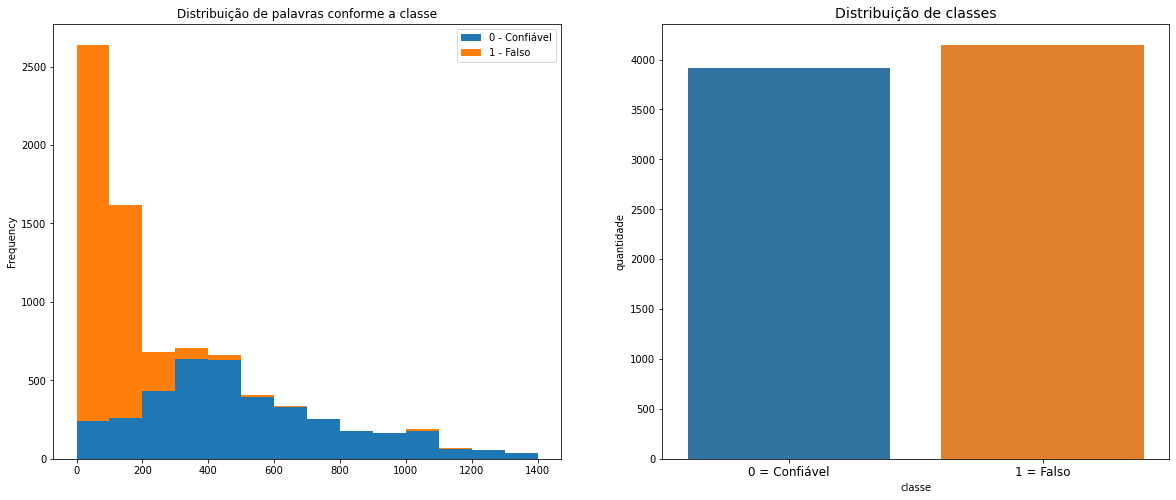

In [35]:
dfplot = dados.pivot(columns='classe').qtde_palavras
dfplot.columns = ['0 - Confiável', '1 - Falso']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
axes1 = dfplot.plot(
    ax=axes[0], kind='hist', stacked=True, bins=list(range(0, 1500, 100)), 
    title="Distribuição de palavras conforme a classe")
axes2 = sns.countplot(x="classe", data=dados)
axes2.set_xticklabels(["0 = Confiável", "1 = Falso"], fontsize=12)
axes2.set_title('Distribuição de classes', fontsize=14)
axes2.set_ylabel('quantidade')

In [36]:
# Salva dados para uso no notebook do próximo passo.
dados.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_tratado.csv', sep = ',')